In [5]:
!pip install qunetsim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eqsn: filename=EQSN-0.0.8-py3-none-any.whl size=11939 sha256=56872d66cefdb745611308e42b3d24f4734fe1ad45ed766123a76798eb99cf32
  Stored in directory: /root/.cache/pip/wheels/8a/08/eb/10ad0fdccd7b467213f43da4dbc9c793c1b31259681cc92d7a
Successfully built eqsn


In [6]:
from qunetsim.components import Host, Network
from qunetsim.objects import Qubit
import random
import numpy as np

In [7]:
class BB84Simulation:
    def __init__(self, num_bits):
        self.num_bits = num_bits
        self.network = Network.get_instance()
        self.network.start(['Alice', 'Bob', 'Eve'])
        self.alice = Host('Alice')
        self.bob = Host('Bob')
        self.eve = Host('Eve')
        self.alice.start()
        self.bob.start()
        self.eve.start()

    def generate_bits_and_basis(self):
        bits = [random.randint(0, 1) for _ in range(self.num_bits)]
        basis = [random.choice(['H', 'V']) for _ in range(self.num_bits)]
        return bits, basis

    def encode_qubit(self, host, bit, basis):
        q = Qubit(host)
        if basis == 'H':
            if bit == 1:
                q.X()
        elif basis == 'V':
            q.H()
            if bit == 1:
                q.X()
        return q

    def simulate_eavesdropping(self, qubit, basis):
        if basis == 'V':
            return random.choice([0, 1])
        return random.choice([0, 1])

    def measure_qubit(self, qubit, basis):
        if basis == 'V':
            qubit.H()
        measured_result = qubit.measure()
        return measured_result

    def run_simulation(self, with_eavesdropper=False):
        alice_bits, alice_basis = self.generate_bits_and_basis()
        bob_basis = self.generate_bits_and_basis()[1]

        # Encode qubits at Alice's side
        alice_to_bob_qubits = [self.encode_qubit(self.alice, bit, basis) for bit, basis in zip(alice_bits, alice_basis)]
        eve_measurements = []

        if with_eavesdropper:
            eve_measurements = [self.simulate_eavesdropping(q, alice_basis[i]) for i, q in enumerate(alice_to_bob_qubits) if alice_basis[i] == bob_basis[i]]

        # Bob measures the qubits received
        bob_measurements = [self.measure_qubit(q, basis) for q, basis in zip(alice_to_bob_qubits, bob_basis)]

        # Compare bases to get matched bits
        matched_indices, alice_matched_bits, bob_matched_bits = self.compare_bases(alice_basis, bob_basis, alice_bits, bob_measurements)
        error_rate = self.calculate_error_rate(alice_matched_bits, bob_matched_bits)

        features = extract_features(alice_matched_bits, bob_matched_bits, error_rate, with_eavesdropper, eve_measurements)
        return features
    def compare_bases(self, alice_basis, bob_basis, alice_bits, bob_measurements):
        matched_indices = [i for i in range(len(alice_basis)) if alice_basis[i] == bob_basis[i]]
        alice_matched_bits = [alice_bits[i] for i in matched_indices]
        bob_matched_bits = [bob_measurements[i] for i in matched_indices]
        return matched_indices, alice_matched_bits, bob_matched_bits

    def calculate_error_rate(self, alice_matched_bits, bob_matched_bits):
        errors = sum(a != b for a, b in zip(alice_matched_bits, bob_matched_bits))
        error_rate = errors / len(alice_matched_bits) if alice_matched_bits else 0
        return error_rate

    def stop(self):
        self.network.stop()
        self.alice.stop()
        self.bob.stop()
        self.eve.stop()


In [88]:
def extract_features(alice_matched_bits, bob_matched_bits, error_rate, include_eve, eve_measurements=None):
    initial_bits = np.array(alice_matched_bits)
    final_key = np.array([0 if bit == 0 else 1 for bit in alice_matched_bits])
    error_correction_rate = 1 - error_rate
    parity_a = np.sum(initial_bits) % 2
    v_bit_probability = np.sum(initial_bits) / len(alice_matched_bits) if alice_matched_bits else 0
    base_mismatch_percentage = np.sum(initial_bits != np.array(bob_matched_bits)) / len(alice_matched_bits) if alice_matched_bits else 0

    if include_eve and eve_measurements is not None:
        eve_mismatch_percentage = np.sum(initial_bits != np.array(eve_measurements)) / len(alice_matched_bits) if alice_matched_bits else 0
        hamming_distance_ae = np.sum(initial_bits != np.array(eve_measurements))
        key_agreement_ratio_ae = np.sum(final_key == np.array(eve_measurements)) / len(alice_matched_bits) if alice_matched_bits else 0
    else:
        eve_mismatch_percentage = -1  # Indicates absence or irrelevance of Eve's measurements
        hamming_distance_ae = -1  # Same as above
        key_agreement_ratio_ae = -1  # Same as above

    hamming_distance_ab = np.sum(initial_bits != np.array(bob_matched_bits))
    key_agreement_ratio_ab = np.sum(final_key == np.array(bob_matched_bits)) / len(alice_matched_bits) if alice_matched_bits else 0

    features = [
        *initial_bits.tolist(),
        *final_key.tolist(),
        error_correction_rate,
        parity_a,
        v_bit_probability,
        base_mismatch_percentage,
        eve_mismatch_percentage,
        hamming_distance_ab,
        hamming_distance_ae,
        key_agreement_ratio_ab,
        key_agreement_ratio_ae
    ]

    return features

In [129]:
num_simulations = 100
features_with_eve = []
features_without_eve = []

bb84_sim = BB84Simulation(10)

for _ in range(num_simulations):
    features_with_eve.append(bb84_sim.run_simulation(with_eavesdropper=True))
    features_without_eve.append(bb84_sim.run_simulation(with_eavesdropper=False))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [139]:
def flatten_features(features):
    standardized_length = 20
    flattened_features = []

    for feature in features:
        if any(isinstance(i, list) for i in feature):
            flattened = [item for sublist in feature for item in (sublist if isinstance(sublist, list) else [sublist])]
        else:
            flattened = feature


        if len(flattened) < standardized_length:
            flattened.extend([-1] * (standardized_length - len(flattened)))


        flattened = flattened[:standardized_length]


        flattened = [float(item) for item in flattened]

        flattened_features.append(flattened)

    return np.array(flattened_features)

X_without_eve = flatten_features(features_without_eve)
y_without_eve = np.array([0]*len(features_without_eve))
X_with_eve = flatten_features(features_with_eve)
y_with_eve = np.array([1] * len(features_with_eve))

X = np.concatenate((X_without_eve, X_with_eve), axis=0)
y = np.concatenate((y_without_eve, y_with_eve), axis=0)

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=120, batch_size=32, validation_split=0.1)

Epoch 1/120
5/5 [==============================] - 4s 88ms/step - loss: 0.7257 - accuracy: 0.5764 - val_loss: 0.6789 - val_accuracy: 0.6250
Epoch 2/120
5/5 [==============================] - 0s 19ms/step - loss: 0.6180 - accuracy: 0.6806 - val_loss: 0.6131 - val_accuracy: 0.6250
Epoch 3/120
5/5 [==============================] - 0s 20ms/step - loss: 0.5516 - accuracy: 0.7986 - val_loss: 0.5640 - val_accuracy: 0.6875
Epoch 4/120
5/5 [==============================] - 0s 20ms/step - loss: 0.4986 - accuracy: 0.8333 - val_loss: 0.5280 - val_accuracy: 0.7500
Epoch 5/120
5/5 [==============================] - 0s 19ms/step - loss: 0.4543 - accuracy: 0.8542 - val_loss: 0.4995 - val_accuracy: 0.7500
Epoch 6/120
5/5 [==============================] - 0s 20ms/step - loss: 0.4193 - accuracy: 0.8819 - val_loss: 0.4746 - val_accuracy: 0.7500
Epoch 7/120
5/5 [==============================] - 0s 20ms/step - loss: 0.3864 - accuracy: 0.9306 - val_loss: 0.4483 - val_accuracy: 0.7500
Epoch 8/120
5/5 [===

In [157]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.2f}")


2/2 [==============================] - 0s 8ms/step - loss: 0.1661 - accuracy: 0.9500
Test accuracy: 0.95


2/2 [==============================] - 0s 6ms/step


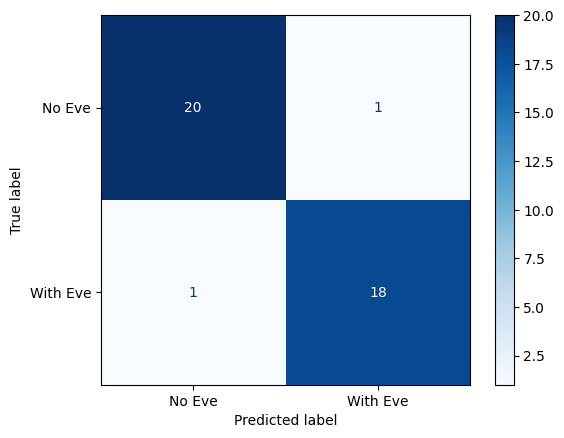

In [150]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test).round()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Eve', 'With Eve'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [151]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Specificity (True Negative Rate): {specificity:.4f}')


Accuracy: 0.9500
Precision: 0.9474
Recall (Sensitivity): 0.9474
F1 Score: 0.9474
Specificity (True Negative Rate): 0.9524
